In [478]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [479]:
from config import path_to_repository
from analysis import BallBearingData # class for extracting all data from application and reapplication for ADC, IMU, and Camera Triggers
from analysis import DLC3DBendAngles # class for taking DLC 3d point data and converting to angles 
from analysis import bender_class # class for normalizing adc data, analyzing autobender tests
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [480]:
# Upload ball bearing and beaker Trials from particpant
# Upload only the parent *date* folder (e.g., "9_19_25").
# If something fails, verify your folder structure matches the "9_19_25" example.

root_dir="CSV Data/11_7_25"
folder_suffix="imu_vfas"

#10_28_25 (Tom)
#10_29_25 (bending data might be okay...check)
#11_2_25 (good)
#11_4_25 (good)

##################### raw adc or imu data for any test ###############################

bb = BallBearingData(
    root_dir=root_dir, # all that is needed is to upload the parent date folder.  If there are issues with this, check the structure of folder 9_19_25 as an example 
    path_to_repo=path_to_repository,
    n_trials_per_set=2,   # 15 trials of ball bearing reach to pinch, 15 trials of beaker reach to grasp, and the same for reapplication
    files_per_trial=7,
    folder_suffix=folder_suffix,     # this suffic contains data from ball bearing task  
    # Valid folder_suffix values (examples): check the 9_19_25 folder for CSV naming patterns/suffixes
)
df_first  = bb.load_first() # first application
df_second = bb.load_second() # reapplication

Found 4 *_imu_vfas folders total (case-insensitive).
  example: C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\CSV Data\11_7_25\2025_11_07_10_22_56_imu_vfas
First set range: 2025_11_07_10_22_56_imu_vfas → 2025_11_07_10_23_16_imu_vfas
Second set range: 2025_11_07_11_13_23_imu_vfas → 2025_11_07_11_13_51_imu_vfas
[WARN] ball_bearing_first: Some trials do not have exactly 7 CSVs:
  • Trial 01: 2025_11_07_10_22_56_imu_vfas has 6 CSVs (including nested)
  • Trial 02: 2025_11_07_10_23_16_imu_vfas has 6 CSVs (including nested)
First set range: 2025_11_07_10_22_56_imu_vfas → 2025_11_07_10_23_16_imu_vfas
Second set range: 2025_11_07_11_13_23_imu_vfas → 2025_11_07_11_13_51_imu_vfas
[WARN] ball_bearing_second: Some trials do not have exactly 7 CSVs:
  • Trial 01: 2025_11_07_11_13_23_imu_vfas has 6 CSVs (including nested)
  • Trial 02: 2025_11_07_11_13_51_imu_vfas has 6 CSVs (including nested)


# Get per-trial camera timestamp tables from flir.mat (prefix 'ts*') and DLC 3D point data (two separate dataframes)

This is where you should probably also load the DLC data and combine with cam_trials_first and cam_trials_second.    See my BallBearingClass for examples of how to do that.  

In [482]:
# FIRST application (camera + DLC should be 'first_cam')
cam_trials_first = bb.extract_mat_dfs_by_trial(
    df_first, mat_name="flir.mat", prefix="ts",
    add_labels=True, trial_base=1, set_label="first_cam", include_path=True
)
dlc3d_trials_first = bb.extract_dlc3d_dfs_by_trial(
    df_first,
    add_labels=True, trial_base=1, set_label="first_cam", include_path=True
)

# SECOND application (camera + DLC should be 'second_cam')
cam_trials_second = bb.extract_mat_dfs_by_trial(
    df_second, mat_name="flir.mat", prefix="ts",
    add_labels=True, trial_base=1, set_label="second_cam", include_path=True
)
dlc3d_trials_second = bb.extract_dlc3d_dfs_by_trial(
    df_second,
    add_labels=True, trial_base=1, set_label="second_cam", include_path=True
)

# --- Build DLC angle tables for FIRST and SECOND sets ---


# 2) Coerce headers to the expected MultiIndex format
dlc3d_trials_first  = [bb._coerce_dlc3d_multiindex(d)  for d in dlc3d_trials_first]
dlc3d_trials_second = [bb._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]

# 3) Compute DLC-derived angles (returns per-trial augmented dfs + tall table)
aug_first,  tall_first  = bb.compute_dlc3d_angles_by_trial(
    dlc3d_trials_first,  set_label="first_cam",  signed_in_plane=True
)
aug_second, tall_second = bb.compute_dlc3d_angles_by_trial(
    dlc3d_trials_second, set_label="second_cam", signed_in_plane=True
)

# (Optional sanity)
print("len(aug_first) vs cam_trials_first:",  len(aug_first),  "vs", len(cam_trials_first))
print("len(aug_second) vs cam_trials_second:", len(aug_second), "vs", len(cam_trials_second))




len(aug_first) vs cam_trials_first: 2 vs 2
len(aug_second) vs cam_trials_second: 2 vs 2


# Convert 3d Data from DLC to angles and append that column to dataframes created in previous cell

See camera_encoder_cal notebook for how this is done using a class method.  

Once you have the angles, can match timestamps below and do error analysis

In [484]:
# ==== prerequisites ====
import pandas as pd

ALLOWED = {"first_block","first_cam","second_block","second_cam"}
REMAP = {
    "first cam":"first_cam","first block":"first_block",
    "second cam":"second_cam","second block":"second_block",
}

def _canon_label(s: str) -> str:
    s = (s or "").strip()
    s = REMAP.get(s, s)
    if s not in ALLOWED:
        raise ValueError(f"Unexpected set_label='{s}'. Must be one of {sorted(ALLOWED)}")
    return s

def _strip_dlc_cols(list_of_dfs):
    """Remove any previously attached DLC metric columns (ending with '_dlc')."""
    out = []
    for df in (list_of_dfs or []):
        if df is None or df.empty:
            out.append(df); continue
        drop_cols = [c for c in df.columns if str(c).endswith("_dlc")]
        out.append(df.drop(columns=drop_cols, errors="ignore"))
    return out

def labels_from_cam(cam_list):
    """Robust per-trial label extraction from camera(+dlc) dfs."""
    out = []
    for i, df in enumerate(cam_list):
        if df is None or df.empty:
            continue
        if "trial" in df.columns:
            s = pd.to_numeric(df["trial"], errors="coerce").dropna().astype(int)
            if not s.empty:
                out.append(int(s.mode().iat[0])); continue
        out.append(len(out)+1)  # 1-based fallback
    return out

def duplicate_trial_labels(labels):
    """[1,2,3] -> [1,1,2,2,3,3]"""
    return [x for t in labels for x in (t, t)]

def duplicate_set_labels_for_four(cal_cam_list, cam_label: str, block_label: str, trial_labels=None):
    """
    Duplicate each per-trial camera(+dlc) df so we get *both* entries:
    cam_label (e.g., 'first_cam') and block_label (e.g., 'first_block').
    Also stamps a consistent 'trial' on both copies.
    Order: [cam, block, cam, block, ...]
    """
    cam_label   = _canon_label(cam_label)
    block_label = _canon_label(block_label)

    out = []
    for i, df in enumerate(cal_cam_list):
        if df is None or df.empty:
            out.extend([df, df]); continue

        # decide the trial id for this element
        if trial_labels is not None:
            t = int(trial_labels[i])
        elif "trial" in df.columns:
            t = int(pd.to_numeric(df["trial"], errors="coerce").dropna().mode().iat[0])
        else:
            t = i+1  # 1-based fallback

        a = df.copy(); a["set_label"] = cam_label;   a["trial"] = t
        b = df.copy(); b["set_label"] = block_label; b["trial"] = t
        out.extend([a, b])
    return out

def show_labels(lst, name):
    s=set()
    for d in lst or []:
        if d is not None and not d.empty and "set_label" in d.columns:
            s |= set(d["set_label"].astype(str).unique())
    print(name, "->", sorted(s))


# ==== 2) attach DLC angles into NEW variables (avoid overwriting raw lists) ====
cam_trials_first_cam = bb.attach_dlc_angles_to_cam_by_trial(
    cam_trials_first,  aug_first,
    add_labels=True, set_label="first_cam", trial_base=1
)
cam_trials_second_cam = bb.attach_dlc_angles_to_cam_by_trial(
    cam_trials_second, aug_second,
    add_labels=True, set_label="second_cam", trial_base=1
)


# Trial labels derived from the stamped 'trial' columns in the *_cam lists
labels_first  = labels_from_cam(cam_trials_first_cam)
labels_second = labels_from_cam(cam_trials_second_cam)

# ==== 3) duplicate to get the FOUR canonical set_labels ====
cam_plus_dlc_first_four = duplicate_set_labels_for_four(
    cam_trials_first_cam, cam_label="first_cam", block_label="first_block",
    #trial_labels=labels_first
)
cam_plus_dlc_second_four = duplicate_set_labels_for_four(
    cam_trials_second_cam, cam_label="second_cam", block_label="second_block",
    #trial_labels=labels_second
)

labels_first_four  = duplicate_trial_labels(labels_first)
labels_second_four = duplicate_trial_labels(labels_second)

# ==== sanity ====
show_labels(cam_plus_dlc_first_four,  "first_four")    # -> ['first_block','first_cam']
show_labels(cam_plus_dlc_second_four, "second_four")   # -> ['second_block','second_cam']




first_four -> ['first_block', 'first_cam']
second_four -> ['second_block', 'second_cam']


## IMU Analysis of Wrist Bend Angles Here

In [486]:

# 2) Extract IMU trials (same calls as before)
imu_trials_first  = bb.extract_imu_dfs_by_trial(df_first)      # list length = bb.n_trials_per_set
imu_trials_second = bb.extract_imu_dfs_by_trial(df_second)

print(f"First set:  {len(imu_trials_first)} IMU trials")
print(f"Second set: {len(imu_trials_second)} IMU trials")


# 3) Access a single trial (unchanged)
trial1_imu = imu_trials_first[0]   # 0-based index -> trial 1




First set:  2 IMU trials
Second set: 2 IMU trials


## Compute bend angle from two IMU's

In [488]:
# ========================= IMU → joint-angle math overview =========================
# We mount two IMUs:
#   • IMU1 ("fixed"): reference segment (watch)
#   • IMU2 ("moving"): distal segment (hand/palm)
#
# Each IMU streams orientation as a unit quaternion q = [w, x, y, z] in some order
# (here 'wxyz'; change QUAT_ORDER if your data is 'xyzw'). A unit quaternion
# represents a 3D rotation R(q) with no gimbal lock and stable interpolation.
#
# Goal: compute the bend angle between a chosen axis on the fixed segment and a
# chosen axis on the moving segment, *as seen in the fixed segment’s frame*.
#
# Math (conceptual):
#   1) Convert both quaternions to rotation matrices:
#        R_fixed = R(q_fixed), R_moving = R(q_moving)
#
#   2) Bring the moving frame into the fixed frame via the relative rotation:
#        R_rel = R_fixed^T · R_moving
#
#   3) Choose body axes (e.g., axis pointing down the index-finger direction):
#        e_fix  = unit axis on the fixed body (x/y/z in IMU1's body frame)
#        e_move = unit axis on the moving body (x/y/z in IMU2's body frame)
#        The strings FIXED_AXIS and MOVING_AXIS select which canonical axis ('x', 'y', or 'z').
#
# Notes:
# - Pick axes that align with the physical direction you want to measure (e.g., IMU1's y-axis along forearm, IMU2's x-axis along palm/fingers).
# - If your hardware mounting changes, update FIXED_AXIS/MOVING_AXIS accordingly.

# Examples (choose letters that match how your sensors are physically mounted):
#
# A) Common mounting:
#    - IMU1 (forearm/watch) mounted so its body y-axis points along the forearm (elbow→wrist).
#    - IMU2 (palm) mounted so its body x-axis points down the fingers (wrist→index tip).
#    -> FIXED_AXIS  = "y"   # e_fix = [0,1,0] in IMU1 body frame
#       MOVING_AXIS = "x"   # e_move = [0,1,0] in IMU2 body frame
#
# B) Rolled/yawed mount where IMU1's body z-axis ends up pointing down the index finger:
#    - After mounting, the direction you care about corresponds to IMU1's z-axis.
#    -> FIXED_AXIS  = "z"
#       MOVING_AXIS = "x"   # (or "y"/"z") pick the IMU2 axis that tracks the palm/fingers best
#
# C) IMU2 flipped 180 deg around its y-axis (so x flips sign):
#    - If your angles look inverted, try switching MOVING_AXIS letter:
#    -> previous: MOVING_AXIS = "x"
#       try:      MOVING_AXIS = "z"  (or "y") depending on which axis now aligns with finger direction
#
# D) Both sensors mounted with their x-axes along the limb segments:
#    -> FIXED_AXIS  = "y"
#       MOVING_AXIS = "y"
#
# E) Quick calibration tip:
#    - Hold a neutral pose, compute R_fixed and R_moving from quats.
#    - Test which body axis (x/y/z) for each IMU has the largest dot product with your intended anatomical direction.
#      Pick that letter as FIXED_AXIS / MOVING_AXIS.
#
#   4) Rotate the moving axis into the fixed frame:
#        v = R_rel · e_move
#
#   5) Bend angle is the angle between v and e_fix in the fixed frame:
#        theta = arccos( clamp( v · e_fix, -1, 1 ) )
#
#      • If you need a *signed* angle in a specific plane, you can project onto a plane
#        and use cross products to set the sign. The pipeline here computes a principal
#        (unsigned) angle consistent with the axis choices.
#      • Units: theta is computed in radians then converted to degrees for convenience.
#
# Why axis choices matter:
#   • Your physical mounting determines which body axis of each IMU best tracks the
#     bending direction. For Tom’s data, IMU1 (watch) was against a vertical wall and
#     IMU2 (palm) faced along the hand toward the fingers, so FIXED_AXIS and MOVING_AXIS
#     are set to align with those physical directions. If your mounting changes, update
#     FIXED_AXIS/MOVING_AXIS to match the true “bend” axes.
#
# Quaternion order:
#   • Many devices output [x, y, z, w] (xyzw) while math libraries prefer [w, x, y, z] (wxyz).
#     QUAT_ORDER tells the code how to read your columns and map them correctly before
#     building R(q). If this is wrong, the computed angle will be nonsense.
#



# ---- IMU processing params ----
TRIAL_LEN_SEC = 10.0
QUAT_COLS     = ("euler1", "euler2")   # your columns that carry orientations
FIXED_AXIS    = "y"
MOVING_AXIS   = "y"
QUAT_ORDER    = "wxyz"

# 1) Extract IMU trials
imu_trials_first  = bb.extract_imu_dfs_by_trial(df_first)
imu_trials_second = bb.extract_imu_dfs_by_trial(df_second)

print(f"First set IMU trials: {len(imu_trials_first)}")
print(f"Second set IMU trials: {len(imu_trials_second)}")
assert len(imu_trials_first) > 0 and len(imu_trials_second) > 0, "No IMU trials found."

# 2) Compute IMU bend angle per trial, in place
bb.imu_augment_trials_inplace(
    None,  # <-- not used; pass None
    imu_trials_first,
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)
bb.imu_augment_trials_inplace(
    None,  # <-- not used
    imu_trials_second,
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)

# 3) Build tall frames
A_all = bb.imu_collect_tall(
    imu_trials_first, "first",
    trial_len_sec=TRIAL_LEN_SEC, quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS, moving_axis=MOVING_AXIS, quat_order=QUAT_ORDER,
)
B_all = bb.imu_collect_tall(
    imu_trials_second, "second",
    trial_len_sec=TRIAL_LEN_SEC, quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS, moving_axis=MOVING_AXIS, quat_order=QUAT_ORDER,
)

# Stamp set_label so alignment can require label matches if desired
if not A_all.empty: A_all["set_label"] = "first_cam"
if not B_all.empty: B_all["set_label"] = "second_cam"



First set IMU trials: 2
Second set IMU trials: 2


In [489]:
def _pick_cam_ts(cam_list, default="ts_25185174"):
    for d in cam_list or []:
        if d is not None and not d.empty:
            for c in d.columns:
                if str(c).startswith("ts_"):
                    s = pd.to_numeric(d[c], errors="coerce")
                    if s.notna().sum() > 5 and (s.max() - s.min()) > 0:
                        return c
    return default

def _labels_from_cam(cam_list):
    labs = []
    for d in cam_list or []:
        if d is None or d.empty or "trial" not in d.columns:
            labs.append(None); continue
        t = pd.to_numeric(d["trial"], errors="coerce").dropna().astype(int)
        labs.append(int(t.mode().iat[0]) if not t.empty else None)
    return labs

_cam_ts_first  = _pick_cam_ts(cam_trials_first_cam)
_cam_ts_second = _pick_cam_ts(cam_trials_second_cam)
_labels_first  = _labels_from_cam(cam_trials_first_cam)
_labels_second = _labels_from_cam(cam_trials_second_cam)

print("[cam ts]", _cam_ts_first, _cam_ts_second)

aligned_first_imu = bb.align_theta_all_to_cam_for_set(
    A_all, cam_trials_first_cam,                 # <-- NOT the *_four list
    enc_time_col="timestamp",                    # if A_all lacks 'timestamp', use 'time_s'
    cam_time_col=_cam_ts_first,
    tolerance=10000000,            # start generous
    theta_col="imu_joint_deg_rx_py",
    drop_unmatched=True,
    keep_time_delta=True,
    trial_labels=_labels_first,                  # keeps trial indices consistent
    require_set_label_match=True,                # A_all['set_label']="first_cam"
)

aligned_second_imu = bb.align_theta_all_to_cam_for_set(
    B_all, cam_trials_second_cam,
    enc_time_col="timestamp",
    cam_time_col=_cam_ts_second,
    tolerance=10000000,
    theta_col="imu_joint_deg_rx_py",
    drop_unmatched=True,
    keep_time_delta=True,
    trial_labels=_labels_second,
    require_set_label_match=True,                # B_all['set_label']="second_cam"
)

# Safe peek (avoid IndexError if first slot is empty)
i0 = next((i for i,d in enumerate(aligned_first_imu) if d is not None and not d.empty), None)
print("[aligned_first_imu] first non-empty idx:", i0)
if i0 is not None:
    display(aligned_first_imu[i0].head())


[cam ts] ts_25183199 ts_25183199
[aligned_first_imu] first non-empty idx: 0


,ts_25183199,ts_25185174,trial,set_label_x,source_path,metric_mcp_bend_deg_deg_dlc,metric_wrist_bend_deg_deg_dlc,metric_mcp_bend_in_wrist_plane_deg_deg_dlc,metric_wrist_plane_ok_dlc,_t_ns,...,timestamp,imu_joint_deg_rx_py,time_s,set_label_y,_t_ns_right,enc_time_s,_delta_ns,_delta_ms,_delta_sec,set_label
0,1.023026e+11,1.023026e+11,1,first_cam,C:\Users\toppe\OneDrive - CSU Maritime Academy...,3.552603,3.389471,-3.552603,True,37382617250000,...,102302642013,NaN,0.000000,first_cam,37382642013000,0.000000,24763000.0,24.763,0.024763,first_cam
1,1.023027e+11,1.023027e+11,1,first_cam,C:\Users\toppe\OneDrive - CSU Maritime Academy...,3.640096,3.420178,-3.640096,True,37382668088000,...,102302663594,NaN,0.011862,first_cam,37382663594000,0.021581,-4494000.0,-4.494,-0.004494,first_cam
2,1.023027e+11,1.023027e+11,1,first_cam,C:\Users\toppe\OneDrive - CSU Maritime Academy...,3.856201,3.759736,-3.856201,True,37382715786000,...,102302719867,12.210397,0.041518,first_cam,37382719867000,0.077854,4081000.0,4.081,0.004081,first_cam
3,1.023028e+11,1.023028e+11,1,first_cam,C:\Users\toppe\OneDrive - CSU Maritime Academy...,3.886637,3.753259,-3.886637,True,37382769040000,...,102302771687,7.802000,0.083037,first_cam,37382771687000,0.129674,2647000.0,2.647,0.002647,first_cam
4,1.023028e+11,1.023028e+11,1,first_cam,C:\Users\toppe\OneDrive - CSU Maritime Academy...,3.636664,3.364853,-3.636664,True,37382816541000,...,102302818575,7.893389,0.124555,first_cam,37382818575000,0.176562,2034000.0,2.034,0.002034,first_cam


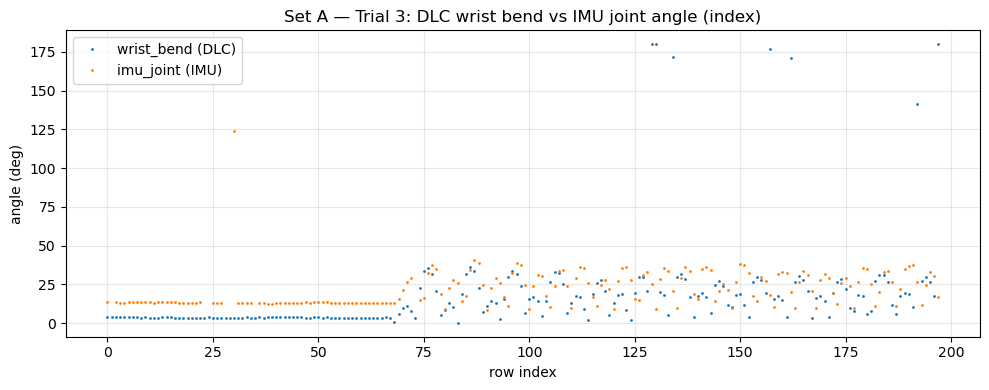

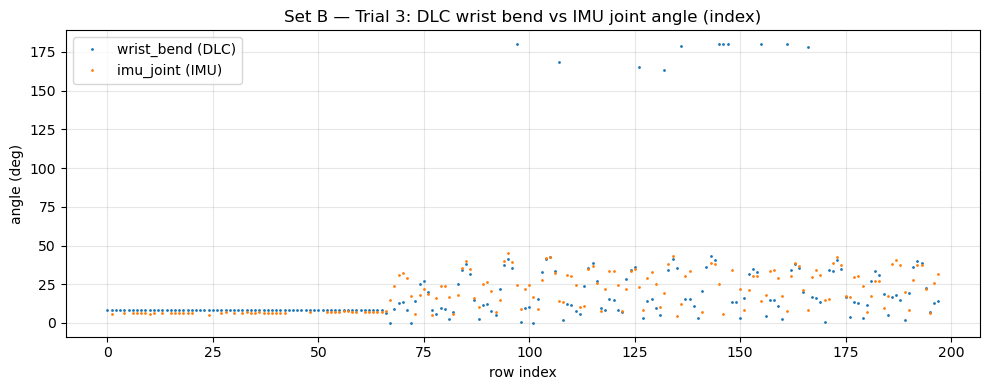

In [490]:
# Plot IMU wrist angle from DLC angle

# Pick a trial (trial 3 => index 2)
t3A = aligned_first_imu[1].reset_index(drop=True)
t3B = aligned_second_imu[1].reset_index(drop=True)

def plot_two_vs_index(df, title):
    col_dlc = "metric_wrist_bend_deg_deg_dlc"
    col_imu = "imu_joint_deg_rx_py"
    fig, ax = plt.subplots(figsize=(10, 4))

    if col_dlc in df.columns:
        ax.plot(df.index, df[col_dlc], ".", markersize=2, label="wrist_bend (DLC)")
    else:
        print(f"[warn] '{col_dlc}' not found. Available: {list(df.columns)}")

    if col_imu in df.columns:
        ax.plot(df.index, df[col_imu], ".", markersize=2, label="imu_joint (IMU)")
    else:
        print(f"[warn] '{col_imu}' not found. Available: {list(df.columns)}")

    ax.set_title(title)
    ax.set_xlabel("row index")
    ax.set_ylabel("angle (deg)")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_two_vs_index(t3A, "Set A — Trial 3: DLC wrist bend vs IMU joint angle (index)")
plot_two_vs_index(t3B, "Set B — Trial 3: DLC wrist bend vs IMU joint angle (index)")


[imu-vs-dlc 2x] set1 trials (0-based): [0, 1] | set2 trials (0-based): [0, 1]


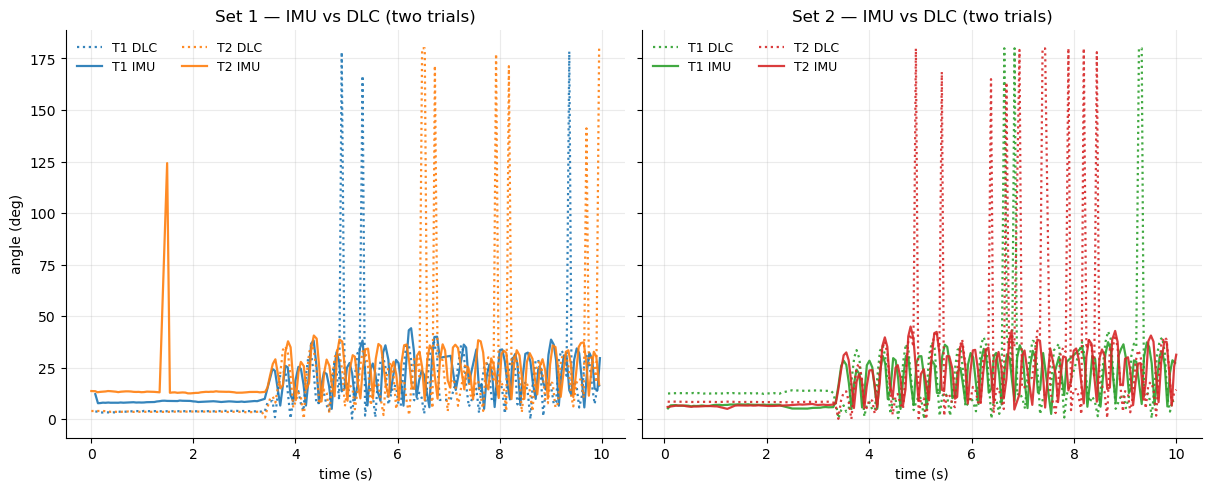

In [491]:
res = bb.plot_imu_vs_dlc_twopanel(
    aligned_first_imu=aligned_first_imu,
    aligned_second_imu=aligned_second_imu,
    dlc_angle_col="metric_wrist_bend_deg_deg_dlc",
    imu_angle_col="imu_joint_deg_rx_py",
    trials_first=None,
    trials_second=None,
    max_abs_dt_ms=100.0,
    verbose=True,
)


[imu-dlc boxplots] set1 trials (0-based): [0, 1], set2 trials (0-based): [0, 1]
[imu-dlc boxplots] done.
{'set1': {'Set1 T1': {'n': 174, 'mean': 11.87340505183388, 'median': 5.689641640640713, 'p90': 21.015589675419573, 'iqr': 10.633159829566011, 'mad': 3.618836452602922}, 'Set1 T2': {'n': 191, 'mean': 17.04605004431599, 'median': 9.724404369004962, 'p90': 25.51997982985699, 'iqr': 7.459448066588964, 'mad': 3.6537415820849795}}, 'set2': {'Set2 T1': {'n': 179, 'mean': 14.059187026128127, 'median': 7.852836634544151, 'p90': 21.846294544112805, 'iqr': 10.756217876559429, 'mad': 2.6493767066283036}, 'Set2 T2': {'n': 171, 'mean': 16.485744326105902, 'median': 4.995193383542996, 'p90': 19.760018180781792, 'iqr': 13.084796824764103, 'mad': 3.8752634982768575}}, 'chosen_trials': {'set1': [0, 1], 'set2': [0, 1]}, 'params': {'dlc_angle_col': 'metric_wrist_bend_deg_deg_dlc', 'imu_angle_col': 'imu_joint_deg_rx_py', 'max_abs_dt_ms': 100.0, 'whisker': 1.5}}


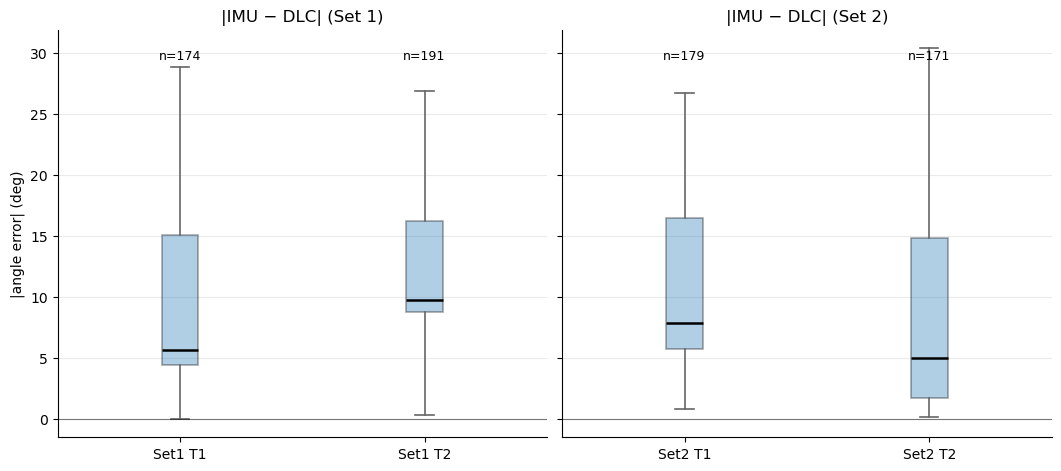

In [492]:
res_imu = bb.plot_imu_dlc_abs_error_boxplots(
    aligned_first_imu=aligned_first_imu,
    aligned_second_imu=aligned_second_imu,
    dlc_angle_col="metric_wrist_bend_deg_deg_dlc",
    imu_angle_col="imu_joint_deg_rx_py",
    # choose specific trials (examples):
    # trials_first=[1, 3], trials_second=[1, 2],   # accepts 1- or 0-based
    trials_first=None,   # auto-pick first two non-empty
    trials_second=None,  # auto-pick first two non-empty
    max_abs_dt_ms=100.0,
    verbose=True,
)
print(res_imu["stats"])
